### Technical Things To Do
- Setup nuts/bolts and try imitation learning on one level (done)
- Optimize imitation learning training on one level
- Setup nuts/bolts and try imitation learning on all levels, test generalization (not strictly necessary for the goal of this work)
- Specify a generic evaluation protocol that can be used for all agents
    - Fixed frame score over a number of evaluation attempts at the same level, mean.
- Try learning from scratch with an RL, record the mean episodic reward throughout training.
- Use the same agent but pre-trained with human demonstrations, record the mean episodic reward throughout training.

In [1]:
import base64
import gym
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import retro
import tensorflow as tf
import time

from gym import wrappers
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/pyt

In [2]:
levels = [
    'MarbleZone.Act1','MarbleZone.Act2','MarbleZone.Act3',
    'GreenHillZone.Act1','GreenHillZone.Act2','GreenHillZone.Act3',
    'LabyrinthZone.Act1','LabyrinthZone.Act2','LabyrinthZone.Act3', 
    'SpringYardZone.Act1','SpringYardZone.Act2','SpringYardZone.Act3', 
    'StarLightZone.Act1','StarLightZone.Act2','StarLightZone.Act3',
    'ScrapBrainZone.Act1','ScrapBrainZone.Act2' 
]

config = {}
config['data_path'] = os.path.abspath("./data/human")
config['level'] = 'GreenHillZone.Act1'

config['epochs'] = 20
config['batches_per_epoch'] = 40
config['batch_size'] = 32
config['patience'] = 5

In [42]:
def extract_human_data(movie_path):
    """ Given a path to a replay file, load it and 
        extract the series of state-action pairs.
    """
    movie = retro.Movie(movie_path)
    movie.step()

    env = retro.make(game=movie.get_game(), state=retro.State.NONE, 
                     use_restricted_actions=retro.Actions.ALL)
    env.initial_state = movie.get_state()
    state = env.reset()
    state = np.swapaxes(state,0,2)
    state = np.swapaxes(state,1,2)
    states, actions, next_states, rewards, dones = [], [], [], [], []
    while movie.step():
        keys = []
        for i in range(len(env.buttons)):
            keys.append(movie.get_key(i, 0))
            
        next_state, reward, done, info = env.step(keys)
        
        # Switch the channels to be first for pytorch
        next_state = np.swapaxes(next_state, 0, 2)
        next_state = np.swapaxes(next_state, 1, 2)
        
        actions.append(np.int8(keys))
        states.append(state)
        next_states.append(next_state)
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
    return states, actions, next_states, rewards, dones

In [43]:
states, actions, next_states, rewards, dones = extract_human_data(f"data/human/SonicTheHedgehog-Genesis-{config['level']}-0000.bk2")

In [44]:
unique_actions, counts = np.unique(actions, axis=0, return_counts=True)

ordering = np.argsort(counts)[::-1]
unique_actions = unique_actions[ordering]
counts = counts[ordering]
print(unique_actions, counts)

[[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]] [1841  881  224  139   38   21   18   16    5    4    3    1]


In [45]:
print(f"Identified {len(counts)} unique actions of {2**12} possible.")

Identified 12 unique actions of 4096 possible.


### Reduced Action Space
Humans are only displaying a very limited subset of the total number of actions possible.  Lets take advantage of this by encoding the action space into a simple integer.

In [46]:
def encode_actions(actions):
    """ Cast actions to a string and then use a label encoder to 
        transform the vector into a simple integer.  
    """
    str_actions = ["".join(str(action)) for action in actions]
    encoder = LabelEncoder()
    return encoder.fit_transform(str_actions)

In [47]:
actions = encode_actions(actions)
n_actions = len(np.unique(actions))
print(n_actions)

12


In [48]:
vector_encoder = OneHotEncoder(sparse=False)
actions = vector_encoder.fit_transform(actions.reshape(-1, 1))

In [49]:
def record_imitation_game(env, model, rnd_steps=50, max_frames=10000):
    """ Docstring.
    """
    
    state = env.reset()
    frames = []
    frames.append(env.render(mode='rgb_array'))
    for step in range(rnd_steps):
        state, _, _, _ = env.step(env.action_space.sample())
        frames.append(env.render(mode='rgb_array'))
        
    done = False
    while not done:
        
        # Act according to our policy most of the time.  It 
        # seems to get stuck so I am trying to add some random
        # elements to get Sonic unstuck.
        if step % 5 == 0:
            new_state, reward, done, info = env.step(env.action_space.sample())
            state = new_state
        
        else:
            action = model.predict(state.reshape(1, *state.shape))
            action = np.round(action[0])
            action = np.array(action, dtype=np.int8)
            new_state, reward, done, info = env.step(action)
            state = new_state
            
        frames.append(env.render(mode='rgb_array'))
        if len(frames) % 500 == 0:
            print("Collected {} frames".format(len(frames)))
        
        if len(frames) >= max_frames:
            return frames
        
    return frames

In [50]:
try:
    import imageio
except:
    !pip install imageio
    !pip install imageio-ffmpeg
    import imageio

In [51]:
#imageio.mimwrite(
#    "imitation_agent_{}.mp4".format(config["level"]), 
#    frames, fps=30)

In [52]:
import torch
import torch.autograd as autograd 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [53]:
states[0].shape

(3, 224, 320)

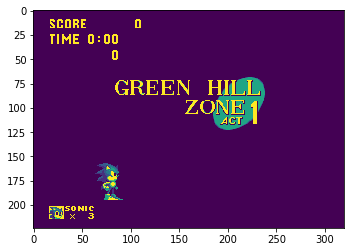

In [54]:
plt.imshow(states[0][0,:,:])

In [55]:
class ImitationModel(nn.Module):
    """ Basic convolutional neural network 
        for imitation learning from Sonic 
        replay data.
    """
    
    def __init__(self, input_shape, output_shape):
        super(ImitationModel, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        channels, height, width = self.input_shape
        self.features = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=3),
            nn.ReLU()
        )
        
        self.fully_connected = nn.Sequential(
            nn.Linear(self._feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, self.output_shape),
            nn.Softmax()
        )
        
    def _feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [56]:
model = ImitationModel(states[0].shape, n_actions)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(states), np.array(actions))

In [66]:
binary_crossentropy = nn.BCELoss()

In [84]:
class ModelTrainer:
    """ Trainer for the imitation learning model.  Since this
        is basic imitation learning, we will minimize the binary
        cross-entropy between action predictions and expert actions.
    """
    def __init__(self, config):
        self.config = config
        self.train_loss = []
        self.test_loss = []
        
        
    def train(self, model, x_train, y_train, x_test, y_test):
        index_pool = np.arange(x_train.shape[0])
        
        for epoch in range(self.config['epochs']):
            epoch_loss = []
            for batch in range(self.config['batches_per_epoch']):
                indices = np.random.choice(index_pool, self.config['batch_size'], replace=False)
                
                # Convert the states and actions to pytorch tensors for 
                # input to the network. 
                x_batch = autograd.Variable(torch.FloatTensor(x_train[indices]))
                y_batch = autograd.Variable(torch.FloatTensor(y_train[indices]))
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                
                # Predict an action
                y_pred = model(x_batch)
                loss = binary_crossentropy(input=y_pred, target=y_batch)
                
                # Optimize on this batch 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss.append(loss.detach().cpu().numpy().mean())
                
            # End of epoch events
            print("Epoch {}, Loss {}".format(epoch, epoch_loss))
            self.train_loss.extend(epoch_loss)

In [85]:
trainer = ModelTrainer(config)
trainer.train(model, x_train, y_train, x_test, y_test)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0, Loss [0.0011706797, 0.008629814, 0.0006395184, 0.0003759875, 0.00016595666, 0.00269462, 7.717596e-05, 0.0011309515, 0.0013094066, 0.002348222, 0.00026309778, 0.0009977516, 0.0008704159, 0.0001770861, 0.00022568439, 0.0012878539, 0.00072678406, 0.00011939332, 0.0069512897, 6.321092e-05, 4.633411e-05, 9.089165e-05, 0.00015857683, 0.001119908, 2.7366894e-05, 8.467075e-05, 0.0038201986, 0.00024392795, 0.00013667815, 0.00034454116, 7.098506e-05, 0.0001214699, 3.8453985e-05, 0.0009717624, 0.00031387905, 0.00044017693, 0.0010445984, 0.00011267498, 0.0011872131, 7.818273e-05]
Epoch 1, Loss [0.0020948492, 0.00011508341, 0.00015661068, 0.019662673, 0.048471596, 0.00012503068, 6.483208e-05, 0.000430844, 0.000104515726, 0.000817996, 0.010817775, 0.0028201826, 0.007343099, 0.00127909, 0.0011529824, 0.0004441794, 0.00039191637, 0.00039997403, 0.00023070362, 0.00067742594, 0.0008737114, 0.00025158955, 0.00010293309, 0.00015895553, 0.00024242078, 0.0013202509, 0.00037363564, 0.022506425, 0.00

Epoch 14, Loss [0.0014788033, 0.0006432044, 0.007180294, 0.0005681822, 0.0006177034, 0.03688992, 0.00015122823, 0.0073411744, 0.0016998494, 0.0014368043, 0.00054330577, 0.00042499797, 0.0001127248, 0.0002376144, 0.009261022, 0.00016980128, 0.0011068798, 0.00034321475, 0.0024476799, 0.00021103489, 0.00012556912, 0.0004109171, 0.00023394528, 2.4041074e-05, 0.00019100697, 0.0003698203, 0.0005184447, 0.00017446793, 0.003033432, 2.7296672e-05, 1.09101675e-05, 5.456238e-05, 8.471456e-05, 0.0078042406, 0.00022803705, 3.7702244e-05, 1.9328889e-05, 6.099283e-05, 5.695154e-05, 6.529953e-05]
Epoch 15, Loss [2.1964988e-05, 8.254409e-05, 0.0068278704, 2.0134985e-05, 0.00034975013, 0.013509553, 0.00032008326, 4.8119768e-05, 2.2611712e-05, 5.1584782e-05, 0.00026708166, 0.0002491535, 1.8046665e-05, 3.0216994e-05, 0.0003202644, 1.454242e-05, 0.0012185558, 0.00017384432, 0.0011295307, 4.2649932e-05, 4.295702e-05, 9.167488e-05, 0.00037916083, 8.8181674e-05, 0.045943182, 6.8026486e-05, 0.00030237428, 0.00

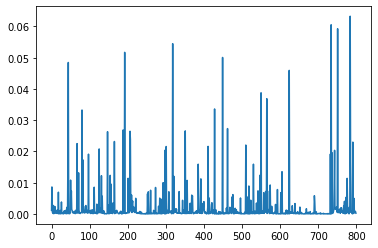

In [86]:
plt.plot(trainer.train_loss)